## Introduction



*   This notebook sets up and trains a neural network to classify images into one of two categories: handwritten 4s and handwritten 9s.


## Import libaries

In [39]:
!pip install keras_tuner

In [40]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import requests
import keras
import keras_tuner
from keras import layers, regularizers
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, TensorBoard
import json
from sklearn.metrics import confusion_matrix

## Loading in MNIST from Keras

The data set for this notebook will consist of handwritten digits imported from Keras data set.

In [41]:
from keras.datasets import mnist

In [42]:
(train_X, y_train), (test_X, y_test) = mnist.load_data()

The MNIST dataset comes pre split into training and test sets.

## Filter data

We want to filter the data set to include only images of the digits 4 and 9.

In [43]:
filtered_train = np.where((y_train == 4) | (y_train == 9))
filtered_test = np.where((y_test == 4) | (y_test == 9))

In [44]:
train_X, y_train = train_X[filtered_train], y_train[filtered_train]
test_X, y_test = test_X[filtered_test], y_test[filtered_test]

Now we have reduced our data set to contain what is relevant to this notebook.

## View shape and images

 Look at the shapes of our training and test sets and visualize some of the images.

In [45]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (11791, 28, 28)
Y_train: (11791,)
X_test:  (1991, 28, 28)
Y_test:  (1991,)


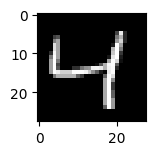

4


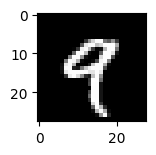

9


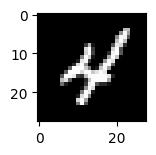

4


In [46]:
for i in range(3):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
  plt.show()
  print(y_train[i])

After looking at the data, we can now reshape and normalize the images to prepare them for training our neural network.

## Flatten images

We now reshape each image into a 1D vector.

In [47]:
train_X.shape

(11791, 28, 28)

In [48]:
X_train = train_X.reshape(train_X.shape[0], -1)

In [49]:
print(X_train.shape)

(11791, 784)


In [50]:
X_test = test_X.reshape(test_X.shape[0], -1)

In [51]:
X_test.shape

(1991, 784)

Reshaping the 2D image into a 1D vector makes it suitable to input into our neural network.

## Normalization

Normalize the features (the pixels) of image data.

In [52]:
X_train_norm = X_train / 255
X_test_norm = X_test / 255

By dividing all pixels by the max pixel magnitude 255, we get values that are between [0, 1].

## Build model

Define and build our neural network model.

In [53]:
def define_model(units, num_layers, activation, lr, l2):
    model_layers = [
        layers.Dense(units, activation=activation, kernel_regularizer=regularizers.L2(l2=l2), kernel_initializer=keras.initializers.HeNormal())
        ] * num_layers
    model_layers += [layers.Dense(10)]
    model = keras.Sequential(model_layers)
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=Adam(learning_rate=lr))

    return model

In [54]:
def build_model(hp):
    units = hp.Choice("units", [256, 512])
    activation = "relu"
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-5, max_value=1e-1, sampling="log")
    num_layers = hp.Choice("num_layers", [2, 3, 4])

    model = define_model(units=units, num_layers=num_layers, activation=activation, lr=lr, l2=l2)
    return model

The define_model function builds a Keras model with the same layer sizes and L2 regularization. The build_model function is passed to the tuner to find the best hyperparameters.

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parameter tuning with Bayesian Optimization

Initializes the tuner object.

In [56]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=8,
    executions_per_trial=1,
    overwrite=False,
    directory="/content/drive/MyDrive/image_classification",
)

Reloading Tuner from /content/drive/MyDrive/image_classification/untitled_project/tuner0.json


In [57]:
callbacks = [EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, start_from_epoch=4)]

The tuner is set to optimize the model based on validation loss, and early stopping is used to check whether the accuracy is still increasing.

## Best Model and Evaluation

Use the tuner to search for the best hyperparameters, and then evaluate the best model on the test data.

In [58]:
tuner.search(
    X_train_norm,
    y_train,
    epochs=8,
    verbose=1,
    validation_data=(X_test_norm, y_test),
    callbacks=callbacks
)

In [59]:
tuner.results_summary(5)

Results summary
Results in /content/drive/MyDrive/image_classification/untitled_project
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
units: 512
lr: 0.0007386457755165143
l2: 0.00019497217747107664
num_layers: 4
Score: 0.05632062628865242

Trial 3 summary
Hyperparameters:
units: 512
lr: 0.0019647765700888434
l2: 0.0016714322755079418
num_layers: 4
Score: 0.06839607656002045

Trial 4 summary
Hyperparameters:
units: 256
lr: 0.01775305777697317
l2: 1.946571389816994e-05
num_layers: 2
Score: 0.0764264166355133

Trial 6 summary
Hyperparameters:
units: 256
lr: 5.401659824126282e-05
l2: 5.5808138488127885e-05
num_layers: 2
Score: 0.08700831979513168

Trial 2 summary
Hyperparameters:
units: 256
lr: 0.01885595480835371
l2: 0.000341579004974261
num_layers: 2
Score: 0.09689763933420181


In [60]:
trial_num = "0"
with open(f"/content/drive/MyDrive/image_classification/untitled_project/trial_{trial_num}/trial.json", "r") as f:
    trial = json.load(f)
hp = trial["hyperparameters"]["values"]
model = define_model(units=hp["units"], num_layers=hp["num_layers"], activation="relu", lr=hp["lr"],
                     l2=hp["l2"])
model.load_weights(f"/content/drive/MyDrive/image_classification/untitled_project/trial_{trial_num}/checkpoint")

In [61]:
y_pred = np.argmax(model.predict(X_test_norm), axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracy = sum(y_pred == y_test) / len(y_test)
print(accuracy)
print(cm)

63/63 [==============================] - 0s 4ms/step
0.9904570567553993
[[ 972   10]
 [   9 1000]]


The best model was number 0 so it was used to make our predictions. Our model had an accuracy of 99.05% when categorizing handwritten 4s and 9s.

## Conclusion

* Using the MNIST dataset, we built and trained a neural network to categorize handwritten 4s and 9s. We optimized our model by finding the best hyperparameters and then applying the model to our test set. This resulted in a 99.05% accuracy, showing the effectiveness of the model.